In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from math import sin, cos, sqrt, atan2, radians
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error

In [2]:
test=pd.read_csv('data/test.csv')
train=pd.read_csv('data/train.csv')
subway=pd.read_csv('data/Subways.csv')
school=pd.read_csv('data/Schools.csv')

In [3]:
train= train.drop_duplicates(train.columns.difference(['key']))

In [4]:
full=pd.concat([train,test],axis=0).reset_index(drop=True)
y=train['transaction_real_price']
full = full.fillna(-999)
full['log_target'] = np.log1p(full['transaction_real_price'])

In [5]:
address_by_law = full['address_by_law'].astype('str')

address_by_law_1 = []
address_by_law_2 = []
address_by_law_3 = []
address_by_law_4 = []

for item in address_by_law:
    address_by_law_1.append(int(item[0:2]))
    address_by_law_2.append(int(item[2:5]))
    address_by_law_3.append(int(item[5:8]))
    address_by_law_4.append(int(item[8:10]))
full['address_by_law_1'] = address_by_law_1
full['address_by_law_2'] = address_by_law_2
full['address_by_law_3'] = address_by_law_3
full['address_by_law_4'] = address_by_law_4
full=full.drop('address_by_law',axis=1)

In [6]:
# new_date = full["transaction_date"].replace({'1~10':'01', '11~20':'10', '21~28':'20', '21~29':'20', '21~30':'20',  '21~31':'20' })
# new_date = full["transaction_year_month"].astype('str') + new_date
# new_date = pd.to_datetime(new_date, format = '%Y%m%d')
# new_date = (new_date - pd.to_datetime("2006-01-01")).dt.days
# full['date'] = new_date

In [7]:
full['transaction_year'] = full['transaction_year_month'].astype(str).map(lambda x: int(x[0:4]))
full['transaction_month'] = full['transaction_year_month'].astype(str).map(lambda x: int(x[4:6]))
full=full.drop('transaction_year_month',axis=1)

In [8]:
# full['transaction_date_label_encoding'] = full['transaction_date'].replace({'1~10':0,'11~20':1,'21~31':2,'21~30':2,'21~29':2,'21~28':2})
# label1, unique1=pd.factorize(full['heat_type'])
# full['heat_type_label_encoding']=label1
# label2, unique2=pd.factorize(full['heat_fuel'])
# full['heat_fuel_label_encoding']=label2
# label3, unique3 = pd.factorize(full['front_door_structure'])
# full['front_door_structure_label_encoding']=label3
# # 위에꺼는 label_encoding이라는 거로 feature를 하나 더 만들어준거다.

full['transaction_date'] = full['transaction_date'].replace({'1~10':0,'11~20':1,'21~31':2,'21~30':2,'21~29':2,'21~28':2})
label1, unique1=pd.factorize(full['heat_type'])
full['heat_type']=label1
label2, unique2=pd.factorize(full['heat_fuel'])
full['heat_fuel']=label2
label3, unique3 = pd.factorize(full['front_door_structure'])
full['front_door_structure']=label3
# 이건 그대로 넣은것

In [9]:
# 이건 위에 encoding할때 새로운 col으로 넣고 categorical data column을 지우기 위해 하는 것
# dtype_df = full.dtypes
# str_idx = dtype_df[dtype_df.values == 'object'].index.tolist()
# full = full.drop(str_idx, axis = 1)

In [10]:
display(subway.head())
display(school.head())

,station_id,latitude,longitude,subway_line,address_by_law
0,1,37.555729,126.972145,"1,4,KJ,AP",1.114012e+09
1,2,37.565624,126.976936,"1,2",1.114017e+09
2,3,37.570169,126.983099,1,1.111013e+09
3,4,37.571570,126.991895,"1,3,5",1.111016e+09
4,5,37.570988,127.001921,1,1.111016e+09


,school_code,latitude,longitude,school_class,operation_type,highschool_type,gender,foundation_date,address_by_law
0,S000003511,37.490880,127.015082,elementary,national,NaN,both,1953.1.31,1165010800
1,S000003563,37.577782,127.002915,elementary,national,NaN,both,1946.8.22,1111016800
2,S010000737,37.481366,127.059055,elementary,public,NaN,both,1982.9.20,1168010300
3,S010000738,37.485744,127.058002,elementary,public,NaN,both,1987.11.17,1168010300
4,S010000741,37.480805,127.051891,elementary,public,NaN,both,1983.11.30,1168010300


In [11]:
def earth(lat1,lat2,lon1,lon2):
    R=6373.0
    distance=[0]*len(lat2)
    for i in range(len(lat2)):
        dlon= lon2[i]- lon1
        dlat= lat2[i]- lat1 
        a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2[i]) * sin(dlon / 2)**2 
        c = 2 * atan2(sqrt(a), sqrt(1 - a)) 
        distance[i] = R * c 
    return distance

In [12]:
X=full.drop_duplicates('apartment_id')
X.reset_index()
nearest_sub = [0]*X.shape[0]
nearest_sub_line = [0]*X.shape[0]
nearest_sch = [0]*X.shape[0]
nearest_sch_class = [0]*X.shape[0]
nearest_sch_type = [0]*X.shape[0]
nearest_sch_gender = [0]*X.shape[0]
nearest_sch_high = [0]*X.shape[0]
nearest_sch_date = [0]*X.shape[0]

for i in range(X.shape[0]):
    subway['dis'] = earth(X.iloc[i]['latitude'],subway['latitude'],X.iloc[i]['longitude'],subway['longitude'])
    min_dist = min(subway['dis'])
    nearest_sub[i] = min_dist
    nearest_sub_line[i] = subway[subway['dis']==min_dist]['subway_line'].values[0]
    
    school['dis'] = earth(X.iloc[i]['latitude'],school['latitude'],X.iloc[i]['longitude'],school['longitude'])
    min_dist_sch = min(school['dis'])
    nearest_sch[i] = min_dist_sch
    nearest_sch_class[i] = school[school['dis']==min_dist_sch]['school_class'].values[0]
    nearest_sch_type[i] = school[school['dis']==min_dist_sch]['operation_type'].values[0]
    nearest_sch_gender[i] = school[school['dis']==min_dist_sch]['gender'].values[0]
    nearest_sch_high[i] = school[school['dis']==min_dist_sch]['highschool_type'].values[0]
    nearest_sch_date[i] = school[school['dis']==min_dist_sch]['foundation_date'].values[0]

In [13]:
X['nearest_sub'] = nearest_sub
X['nearest_sub_line'] = nearest_sub_line
X['nearest_sch'] = nearest_sch
X['nearest_sch_class'] = nearest_sch_class
X['nearest_sch_type'] = nearest_sch_type
X['nearest_sch_gender'] = nearest_sch_gender
X['nearest_sch_high'] = nearest_sch_high
X['nearest_sch_date'] = nearest_sch_date
X.head()

C:\ProgramData\Anaconda3\envs\venv\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
C:\ProgramData\Anaconda3\envs\venv\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\ProgramData\Anaconda3\envs\venv\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the

,key,apartment_id,city,transaction_date,year_of_completion,exclusive_use_area,floor,latitude,longitude,total_parking_capacity_in_site,...,transaction_year,transaction_month,nearest_sub,nearest_sub_line,nearest_sch,nearest_sch_class,nearest_sch_type,nearest_sch_gender,nearest_sch_high,nearest_sch_date
0,0,5584,1,1,1999,47.43,6,37.585965,127.000231,163.0,...,2006,1,24.882336,4,14.901992,middle,private,male,NaN,1907.9.8
2,2,5059,1,1,1992,54.70,8,37.580511,127.014016,902.0,...,2006,1,8.067028,6,6.109126,elementary,public,both,NaN,1971.10.6
3,3,2816,1,1,1993,64.66,11,37.580324,127.011788,902.0,...,2006,1,21.581305,6,8.018905,high,private,female,specialized,1966.12.8
5,5,2815,1,1,2000,84.92,9,37.575381,126.960804,1365.0,...,2006,1,19.187394,3,8.679184,elementary,public,both,NaN,1957.9.28
7,7,9867,1,1,2005,84.76,10,37.559200,127.019503,652.0,...,2006,1,31.254636,5,7.314980,middle,public,female,NaN,1968.8.6


In [14]:
full=pd.merge(full,X[['apartment_id','nearest_sub','nearest_sub_line','nearest_sch','nearest_sch_class',
                      'nearest_sch_type','nearest_sch_gender','nearest_sch_high','nearest_sch_date']],
                      left_on='apartment_id',right_on='apartment_id',how='left')

In [15]:
label1, unique1=pd.factorize(full['nearest_sch_class'])
full['nearest_sch_class']=label1
label2, unique2=pd.factorize(full['nearest_sch_type'])
full['nearest_sch_type']=label2
label3, unique3=pd.factorize(full['nearest_sch_gender'])
full['nearest_sch_gender']=label3
label4, unique4=pd.factorize(full['nearest_sch_high'])
full['nearest_sch_high']=label4

In [16]:
full['nearest_sch_high']=full['nearest_sch_high'].replace({-1:-999})

In [17]:
X=full.drop_duplicates('apartment_id')
X_S=X[X['city']==1]
X_B=X[X['city']==0]
COOR_S=X_S[['apartment_id','latitude','longitude']]
COOR_B=X_B[['apartment_id','latitude','longitude']]
COOR_S.reset_index
COOR_B.reset_index

# Agg_S=AgglomerativeClustering(n_clusters=70, affinity='euclidean', linkage='ward').fit_predict(COOR_S[['latitude','longitude']])
# Agg_B=AgglomerativeClustering(n_clusters=50, affinity='euclidean', linkage='ward').fit_predict(COOR_B[['latitude','longitude']])
kmeans_S = KMeans(n_clusters=70, random_state=0).fit(COOR_S[['latitude','longitude']])
kmeans_B = KMeans(n_clusters=50, random_state=0).fit(COOR_B[['latitude','longitude']])

In [18]:
# COOR_S['cluster_N']=Agg_S
# COOR_B['cluster_N']=Agg_B

COOR_S['cluster_N']=kmeans_S.labels_
COOR_B['cluster_N']=kmeans_B.labels_

C:\ProgramData\Anaconda3\envs\venv\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
C:\ProgramData\Anaconda3\envs\venv\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


In [19]:
COOR_B['cluster_N']+=70
COOR=pd.concat([COOR_S,COOR_B])
full=pd.merge(full,COOR,left_on='apartment_id',right_on='apartment_id',how='left')
full=full.drop(['latitude_y','longitude_y'],axis=1)

C:\ProgramData\Anaconda3\envs\venv\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [20]:
full=full.drop(['nearest_sch_date','nearest_sub_line'],axis=1)

In [21]:
val_key = pd.read_csv("data/val_key.csv")
val_key = val_key[val_key['val_key'] > 0].val_key.tolist()

train = full.loc[:train.shape[0] - 1,:]
test = full.loc[train.shape[0]:,:].reset_index(drop = True)
val = train[train['key'].isin(val_key)]
train = train.drop(labels = val.index, axis = 0)

print("TRAIN shape : ", train.shape)
print("VAL shape : ", val.shape)
print("TEST shape : ", test.shape)

train.to_csv('data/x_train.csv', encoding = False, index = False)
val.to_csv('data/x_val.csv', encoding = False, index = False)
test.to_csv('data/x_test.csv', encoding = False, index = False)

TRAIN shape :  (1551005, 37)
VAL shape :  (3906, 37)
TEST shape :  (3918, 37)


In [22]:
x_train = pd.read_csv('data/x_train.csv')
x_val = pd.read_csv('data/x_val.csv')

x_train = x_train[x_train['transaction_year'] > 2012]
# x_train = x_train[x_train['date'] > 2555]

y_train = x_train['log_target']
y_val = x_val['log_target']

x_train = x_train.drop(['transaction_real_price', 'log_target'], axis = 1)
features = x_train.columns.tolist()
x_train = x_train.values
x_val = x_val.drop(['transaction_real_price', 'log_target'], axis = 1).values

x_full = np.concatenate((x_train, x_val), axis = 0)
y_full = np.concatenate((y_train, y_val))

print("train shape : ", x_train.shape)
print("val shape : ", x_val.shape)
print("full shape : ", x_full.shape)

train shape :  (835932, 35)
val shape :  (3906, 35)
full shape :  (839838, 35)


In [26]:
model=LGBMRegressor(num_leaves=127,n_estimators=10000,min_child_weight=0.001,learning_rate=0.05)
# model.fit(x_train,y_train)

In [28]:
# model =CatBoostRegressor(iterations=2, depth=2, learning_rate=0.1)
# model.fit(x_train,y_train)
# pred_list=[]
# for n_estimator in list:
#     model=LGBMRegressor(n_estimators=n_estimator)
#     model.fit(x_train,y_train)
#     y_pred = model.predict(x_val)
#     mse = mean_squared_error(np.expm1(y_val), np.expm1(y_pred))
#     pred_list.append(np.sqrt(mse))
# model = XGBRegressor(learning_rate=0.05,max_depth=6,n_estimators=500)
# model.fit(x_train, y_train)
# print(pred_list)
# model.fit(x_train,y_train)

In [24]:
y_pred = model.predict(x_val)
mse = mean_squared_error(np.expm1(y_val), np.expm1(y_pred))
np.sqrt(mse)

56074336.96561679

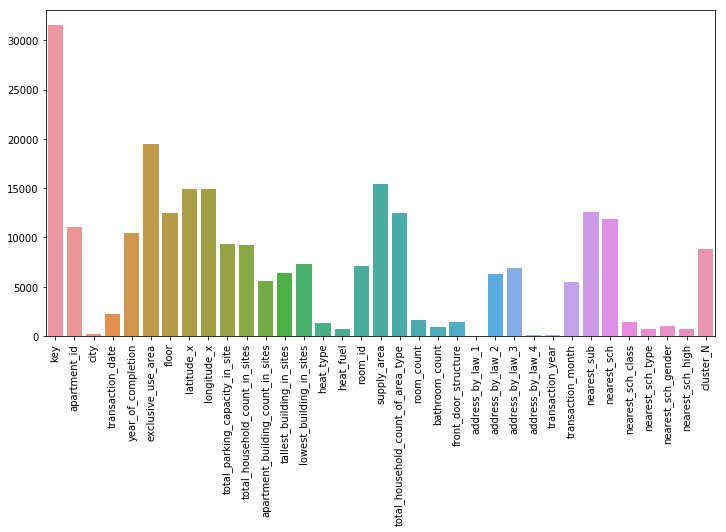

[31515 11062   192  2204 10486 19499 12444 14952 14918  9351  9268  5553
  6427  7253  1358   667  7122 15456 12454  1576   886  1419     2  6263
  6882    97   106  5452 12532 11853  1439   726  1044   677  8865]


In [25]:
plt.figure(figsize = (12, 6))
sns.barplot(x = features, y = model.feature_importances_)
plt.xticks(rotation = 'vertical')
plt.show()
print(model.feature_importances_)

In [18]:
train_pred = model.predict(x_train)
mse = mean_squared_error(np.expm1(y_train), np.expm1(train_pred))
np.sqrt(mse)

21491650.78895946

In [27]:
model.fit(x_full, y_full)

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
       importance_type='split', learning_rate=0.05, max_depth=-1,
       min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
       n_estimators=10000, n_jobs=-1, num_leaves=127, objective=None,
       random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
       subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [28]:
x_test = pd.read_csv('data/x_test.csv')
sub = pd.read_csv('data/submission.csv')
TRAIN = pd.read_csv('data/train.csv')
same_instance = pd.read_csv('data/same_instance.csv')
same_instance.columns = ['apartment_id', 'key']

ret = []
for i, row in same_instance.iterrows():
    ret.append(TRAIN[TRAIN['key'] == row['key']]['transaction_real_price'].values[0])
same_instance['transaction_real_price'] = ret

sub['1st'] = pd.merge(left = x_test, right = same_instance[['apartment_id', 'transaction_real_price']], on = 'apartment_id', how = 'left')['transaction_real_price_y']

x_test = x_test.drop(['transaction_real_price', 'log_target'], axis = 1).values
test_pred = np.expm1(model.predict(x_test))
sub['2nd'] = test_pred

sub = sub.fillna(-1)
ret = []
for i, row in sub.iterrows():
    if row['1st'] != -1:
        ret.append(row['1st'])
    else:
        ret.append(row['2nd'])
sub['transaction_real_price'] = ret

sub = sub.drop(['1st', '2nd'], axis = 1)

sub.to_csv("sub.csv", encoding = False, index = False)